## Model Validation - Loss Distribution
### Quantitative Risk Management
#### Amar Adusumilli
#### 12/05/2020


In [1]:
# Import Packages
import numpy as np 
import pandas as pd
from scipy.stats import kurtosis 
from scipy.stats import skew
from plotnine import *

## Data Exploration: Loss Severity

Skewness and excess kurtosis are calculated below using the `scipy.stats` implementations. Excess kurtosis is calculated by subtracting 3 from the calculated kurtosis of the supplied data, the `scipy.stats.kurtosis` function does this by default. For both skewness and excess kurtosis, the `bias` argument was set to `False` to match the equivalent Excel output exactly. Note that the `bias` argument is counterintuitive, it corrects the skewness and kurtosis calculations for statistical bias when set to `False`.   

In [2]:
# Load Data
LossEvents = pd.read_excel(
    'C:\\Users\\aadus\\OneDrive\\Documents\\GW\\Fall 2020\\Quantitative Risk Management\\Problem Sets\\Pset1\\opsloss_data.xlsx',
     usecols = 'A:C')
# Obtain Skewness and Kurtosis 
pd.DataFrame({'Value': [skew(LossEvents['Amount'], bias = False), kurtosis(LossEvents['Amount'], bias = False)]},
            index = ['Skewness', 'Excess Kurtosis'])


,Value
Skewness,3.979424
Excess Kurtosis,20.228885


#### Histogram

The histogram of raw severities is shown below. The distribution is strongly skewed to the right, consistent with the large skewness value obtained above. 

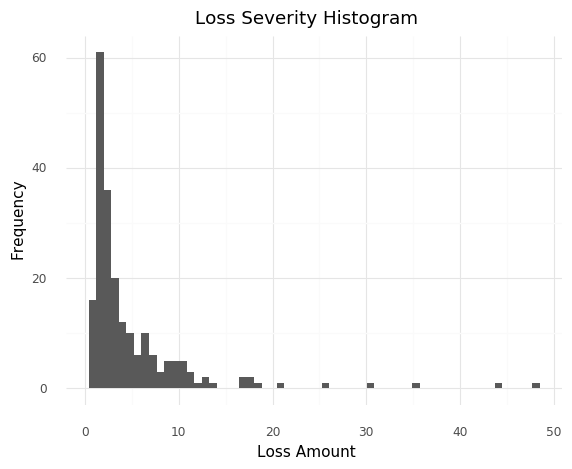

<ggplot: (100081409124)>

In [3]:
# 'Raw' Histogram
(ggplot(LossEvents, aes('Amount'))  
 + geom_histogram(bins = 60) +
 labs(title = 'Loss Severity Histogram', y = 'Frequency', x = 'Loss Amount') 
 + theme_minimal())

#### Lognormal Distribution

The natural log of the amount column is calculated below, along with the descriptive statistics of the logged column. As before, the `bias` argument was set to `False` to match the Excel output exactly. `numpy.std` calculates population standard deviation by default, I have set the `ddof = 1` argument to calculate sample standard deviation instead. With this adjustment, standard deviation matches the Excel output. The histogram of the log losses appears to be far more symmetrical than the level distribution, with excess kurtosis close to 0. A Shapiro test results in a test statistic of `0.99` and a p-value of `0.1749`, meaning that we fail to reject the null of normality. While not conclusive evidence, these results suggest that the logged loss severity can be reasonably approximated by a normal distribution, meaning that the level loss severity can be approximated by a lognormal distribution. 

In [4]:
# Add a column with the natural log of the loss amount 
LossEvents['ln_Amount'] = np.log(LossEvents['Amount'])

# Descriptive Stats - Create DataFrame
Ln_Stats = pd.DataFrame({'Values': [np.mean(LossEvents['ln_Amount']),
                         np.std(LossEvents['ln_Amount'], ddof = 1),
                         skew(LossEvents['ln_Amount'], bias = False),
                         kurtosis(LossEvents['ln_Amount'], bias = False),
                         np.median(LossEvents['ln_Amount'])]},
                       index = ['Mean', 'Sigma', 'Skewness', 'Excess Kurtosis', 'Median'])
# Display Results
Ln_Stats

,Values
Mean,1.159349
Sigma,0.839217
Skewness,0.828241
Excess Kurtosis,0.171467
Median,0.953177


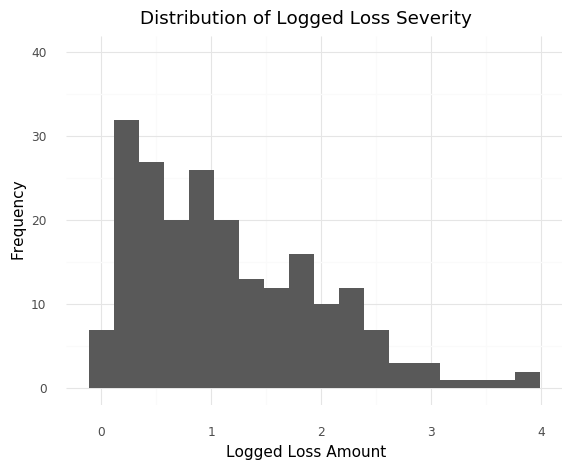

<ggplot: (100083324097)>

In [20]:
# Histogram of Log Losses
(ggplot(LossEvents, aes('ln_Amount'))  
 + geom_histogram(bins = 18) +
 scale_y_continuous(limits =  (0, 40)) +
 labs(title = 'Distribution of Logged Loss Severity', y = 'Frequency', x = 'Logged Loss Amount') 
 + theme_minimal())

## Data Exploration: Loss Frequency

To perform this exercise in python, I have recreated the pivot table output on columns D:F of the 'Periodic Pivot' tab in the Excel worksheet. The descriptive statistics requested are shown below. As noted in the assignment prompt, the variance of the data is larger than the mean. The histogram of event counts is shown below as well.


In [6]:

# Recreate Pivot Table in 'Periodic Pivot' worksheet
EventCounts = LossEvents.groupby('Period')[['Amount']].count().rename(columns = {'Amount': 'Count'})
# Add in the Missing Periods - Create a list of missing periods
def MissingIndex(lst):
    return [i for i in range(lst[0], lst[-1]) if i not in lst]
# Output the List
MissingPeriods = MissingIndex(EventCounts.index.tolist())
# Add the missing value for period 1
MissingPeriods.insert(0, 0)
# Add the missing Periods and Impute with 0's
EventCounts = EventCounts.reindex(EventCounts.index.union(MissingPeriods)).fillna(0)
# Remove

# Descriptive Statistics
FrequencyStats = pd.DataFrame({'Values': [
    np.mean(EventCounts['Count']),
    np.std(EventCounts['Count'], ddof = 1),
    skew(EventCounts['Count'], bias = False)]},
    index = ['Mean', 'Standard Deviation', 'Skewness'])
    
FrequencyStats

,Values
Mean,1.065000
Standard Deviation,1.256451
Skewness,1.427132


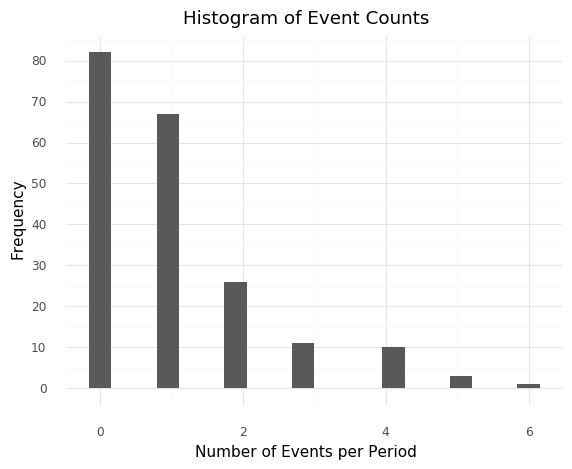

<ggplot: (100081653501)>

In [7]:
# Histogram of Frequencies
(ggplot(EventCounts, aes('Count'))  
 + geom_histogram(bins = 20) +
 scale_y_continuous(breaks = range(0, 90, 10)) + 
 labs(title = 'Histogram of Event Counts', y = 'Frequency', x = 'Number of Events per Period') 
 + theme_minimal())

## Modeling

I have replicated the results of the 'Binom-LN-MC' sheet with the code below. One benefit to using Python rather than Excel is that I can directly utilize the `scipy.stats` implementation of the Poisson distribution rather than approximating it with a binomial distribution. Another benefit is that it is relatively easy to increase the number of trials, which I have set to 100000. First, I construct a dataframe to house the event loss results, in a similar fashion to the table spanning columns `F:T` in the `Binom-LN-MC` tab on the Excel worksheet. 

This dataframe is initially populated with 2 columns, the first (denoted `Trial`) being an integer index that runs from 1 to 100,000. The second column consists of the corresponding Poisson draws, where $\lambda = 1.07$; the mean value of events per period given by the average of the count column in the `Periodic Pivot` sheet. I then add 12 columns consisting of random draws from a lognormal distribution to represent the loss for each event in a given trial, using the `numpy.random` lognormal implementation, with mean and standard deviation calculated from the log loss data. I populate all 12 * 100000 cells with lognormal draws, then filter out draws based on the number of events in a trial. For instance, if a given trial drew $n = 3$ events, then only the first three loss columns will be populated with lognormal draws, and columns 4-12 will consist of 0's. 

I then found total loss by summing across all the individual loss columns. From there, I created the CDF through finding the proportion of total loss values below a series of loss thresholds given by an integer sequence from 0 to 30, then summing over the proportions cumulatively. The PDF is found by differencing consecutive CDF values. Finally, a plot of the PDF is produced, which is visually similar to the example in the assignment document. Excerpts of the `EvenLossSimulation` and `LossDistribution` dataframes are below for the sake of clarity.

In [8]:
# Import Poisson Distribution
from scipy.stats import poisson

# Lognormal mean and standard deviation - calculated from log loss amounts
lognormal_mean = 1.159349
lognormal_stdev = 0.839217

# Set Seed for Reproducability
np.random.seed(seed = 92320)

# Construct a dataframe to house the primary loss results - first, add the trials (100000), and the events per trial (Poisson Draws)
EventLossSimulation = pd.DataFrame({
     'Trial': pd.Series(range(1, 100001)),
     'EventCount': pd.Series(poisson.rvs(1.065000, size = 100000))})

# With the Seed Set, the Maximum number of events is 9 for a given trial
# Now, challenge is to output the corresponding lognormal values for the number of events per trial, and add it to the table
# There is probably a more elegant solution, but for now I will 'brute force'
# Create Empty Columns to house lognormal draws
EmptyCols = ['Loss1', 'Loss2', 'Loss3', 'Loss4', 'Loss5', 'Loss6', 'Loss7', 'Loss8', 'Loss9', 'Loss10', 'Loss11', 'Loss12']
# Add the Columns and the LogNormal Draws into Every Row
for i in EmptyCols:
    EventLossSimulation[i] = np.random.lognormal(mean = lognormal_mean, sigma = lognormal_stdev, size = EventLossSimulation.shape[0])

# Remove Draws from Columns Based on the Number of Trials
for i, j in zip(EmptyCols, list(range(1, 13))):
    EventLossSimulation.loc[EventLossSimulation['EventCount'] < j, i] = 0
    
# Sum all loss columns into the total sum
EventLossSimulation['TotalLoss'] = np.sum(EventLossSimulation.iloc[:, 2:14], axis = 1)

# Construct the Distribution from the Results
LossDistribution = pd.DataFrame({
    'Loss': range(0, 31)})

# Add the Cumulative Probabilities - bin the total loss amounts
LossBins = list(range(0, 32, 1))
# Create a DataFrame With the Proportions by Bin
LossBinsDF = pd.cut(EventLossSimulation['TotalLoss'], bins = LossBins, labels = False, include_lowest = True).value_counts(normalize = True)
# Convert Index to Int to enable merging                                                                                                         
LossBinsDF.index = LossBinsDF.index.astype('int64')

# Merge the Proportion Data with the Loss Simulation DF
LossDistribution = pd.merge(LossDistribution, LossBinsDF, left_index = True, right_index = True, how = 'inner').rename(columns = {'TotalLoss': 'Proportion'})
# Add the CDF - this is the cumulative sum of the proportions
LossDistribution['CDF'] = LossDistribution['Proportion'].cumsum()
# Add the PDF - This is the lagged difference of the CDF values
LossDistribution['PDF'] = LossDistribution['CDF'].diff().fillna(LossDistribution['CDF'])
# Drop the Proportion Column
LossDistribution.drop('Proportion', inplace = True, axis = 1)

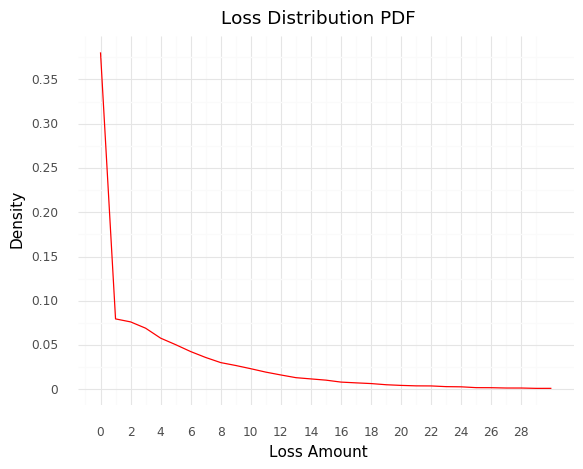

<ggplot: (100081720055)>

In [9]:
# Plot the PDF
(ggplot(LossDistribution, aes('Loss', 'PDF')) +
 geom_line(color = 'red') +
 labs(title = 'Loss Distribution PDF', x = 'Loss Amount', y = 'Density') +
 scale_x_continuous(breaks = range(0, 30, 2)) +
 scale_y_continuous(breaks = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]) +
 theme_minimal())

In [10]:
# Event Loss DataFrame - Excerpt
EventLossSimulation.head()

,Trial,EventCount,Loss1,Loss2,Loss3,Loss4,Loss5,Loss6,Loss7,Loss8,Loss9,Loss10,Loss11,Loss12,TotalLoss
0,1,3,8.852431,2.251635,2.190191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.294257
1,2,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,3,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,4,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,5,2,5.403701,1.957451,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.361152


In [11]:
# Loss Distribution DataFrame
LossDistribution.set_index('Loss')

,CDF,PDF
Loss,,
0,0.380568,0.380568
1,0.460183,0.079615
2,0.536417,0.076235
3,0.605539,0.069122
4,0.663411,0.057872
5,0.713928,0.050517
6,0.756646,0.042718
7,0.792675,0.036029
8,0.822933,0.030258


## Loss Projection

From the loss distribution table above, it is clear that that 90th percentile will lie around a loss of 12. To be more precise, I have recreated the `LossDistribution` DataFrame with an index of 50000 numbers equally spaced between 0 and 30. This approach lets me get arbitrarily close to the true value of the 90th percentile, similar to taking the limit of a function as $x \to a$. This approach leads to a 90th percentile loss estimate of `12.467649`, which is precisely the `0.900006`th percentile. This procedure provides greater accuracy than simply reading off the closest value to 0.9 off of the original `LossDistribution` table.  

In [12]:
# To find 90th percentile, I can create more and more bins to get the CDF values closer and closer to 90
decimalbins = np.linspace(0, 30, num = 50000)
# Find the Proportions
Proportions = pd.cut(EventLossSimulation['TotalLoss'], bins = decimalbins, labels = False, include_lowest = True).value_counts(normalize = True)
# Create a DataFrame to House the Results
PrecisePercentiles = pd.DataFrame({'Loss Amount': pd.Series(decimalbins), 'PDF': Proportions})
# Add the CDF Column
PrecisePercentiles['CDF'] = PrecisePercentiles['PDF'].cumsum()
# Filter on Values Approaching .90
PrecisePercentiles[(PrecisePercentiles['CDF'] > 0.89999) & (PrecisePercentiles['CDF'] < 0.90001)]

,Loss Amount,PDF,CDF
20586.0,12.351847,0.00002,0.900007


In [13]:
EventLossSimulation.iloc[:, 2:14]

,Loss1,Loss2,Loss3,Loss4,Loss5,Loss6,Loss7,Loss8,Loss9,Loss10,Loss11,Loss12
0,8.852431,2.251635,2.190191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.403701,1.957451,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5.847116,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99996,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99997,0.328464,7.466808,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99998,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
